$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
\newcommand{\cop}{\mathrm{COP}}
$$

# TeslaMax Optimization

Teslamax model:

<img src="figures/teslamax.png" width=500>

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)

In [2]:
FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM / 2.54

FONTSIZE = 20



PAPER_FILE_PATH = Path('.')
FIGURES_DIR_NAME = "figures"
FIG_FILE_PATH = PAPER_FILE_PATH / Path(FIGURES_DIR_NAME)


PLOT_EXTENSION = ".png"

DPI = 800

In [11]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [12]:
os.getcwd()

'C:\\Users\\fapfor\\code\\TeslaMax'

In [5]:
def save_figure(fig,name):
    """
    Save the 'fig' Figure object as 'name' (with extension PLOT_EXTENSION), inside FIG_FILE_PATH,
    and close the figure"""
    
    
    file_path = str(FIG_FILE_PATH / (name + PLOT_EXTENSION))
    fig.savefig(file_path,dpi=DPI,bbox_inches='tight')

## AMR simulations

To help determine the best magnetic profile for an AMR device, simulations using the AMR model from Trevizoli (2015) were performed, and can be found in [this repository](https://github.com/PoloMag/paper-magnetic-profiles). We wish then to design the magnet to be able to provide the desired profile.

All simulations considered a ramp profile like this one:

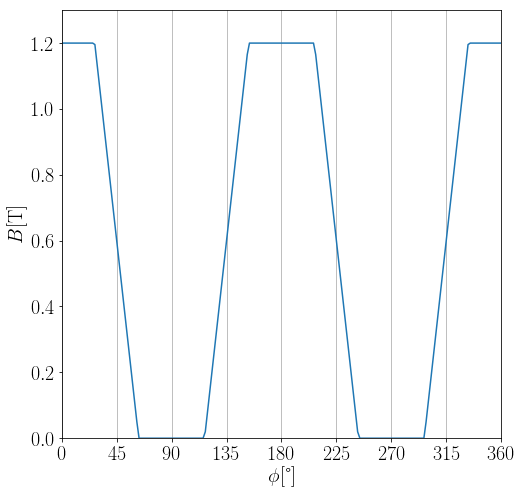

In [6]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

ramp_profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
ramp_profile_axes = ramp_profile_fig.add_subplot(111)

B_high = 1.2
B_low = 0.0
field_fraction = 0.3

phi_vector = np.linspace(0,360,200)
B_ramp_vector = teslamax.calculate_ramp_profile(phi_vector,B_high,B_low,field_fraction)

ramp_profile_axes.plot(phi_vector,B_ramp_vector)
ramp_profile_axes.set_xlim(0,np.max(phi_vector))
ramp_profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
ramp_profile_axes.xaxis.grid(True)
ramp_profile_axes.set_ylim(0,B_high+0.1)
ramp_profile_axes.set_yticks(np.arange(0,B_high+0.2,0.2))
ramp_profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
ramp_profile_axes.set_ylabel(r'$B [\si{\tesla}]$')


The following parameters were kept fixed in all simulations:

In [7]:
FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.5e-3,
    "L[m]": 100e-3,
    "W[m]": 25e-3,
    "H[m]": 20e-3,
    "N_r[]": 11,
    "T_H[K]": 298,
    "dT[K]": 20,
"t_csg[m]": 1e-3,
"t_air[m]": 0.5e-3,
"casing_material": "G10"
}

FIXED_PARAMETERS_AMR["hgap[m]"] = FIXED_PARAMETERS_AMR["H[m]"] + 2*(FIXED_PARAMETERS_AMR["t_csg[m]"] + 
                                                                    FIXED_PARAMETERS_AMR["t_air[m]"])

Thermal losses were included in the simulations

By varying the field fraction $F_M$ (the fraction of the cycle where the field is at the maximum level) and the maximum magnetic field, the following map can be generated, for a combination of frequency, utilization and blow fraction:

<img src="figures/Qc_ramp_map_f_1_Phi_40_FB_70.png" width=600> <img src="figures/COP_ramp_map_f_1_Phi_40_FB_70.png" width=600>

Notice how the results are sensitive to the magnitude of the field. It is more advantangeous to keep the field at 1.4 T during  30% of the cycle than keeping the field at 1.2 T for the entire cycle.

Our current estimative for the cooling capacity for the wine cooler is 180 W @ 0 K and 100 W @ 25 K. From the above figures, we can see that, for $\Phi = 0.4$ and $F\ped{B} = 0.7$, it is possible to achieve $\cop > 2$ when the field is at 1.3 T for 35% of the time, and the cooling capacity at 20 K will be of ca. 170 W.

## Objective function

We consider that the magnetic profile is a good representation of what the regenerators experience, and it is what is used as an input to AMR models. Therefore, the optimization procedure that is developed here is denoted *profile matching*: we calculate the optimal remanence angles for each magnet segments, such that the deviation between the resulting profile and a *target* ramp profile is minimized:

\begin{equation}
\mathcal{K}(\nvector{x}) = \left(\int_0^{2\pi}\left(\average{B}(\phi,\nvector{x}) - \average{B}\ped{ramp} (\phi,B\ped{l},B\ped{h},F\ped{M})\right)^{2}\diffd{\phi}\right)
\end{equation}

where $\average{B}(\phi,\nvector{x})$ is the magnetic profile calculated at position $\phi$ when the remanence angles are represented by $\nvector{x}$, and $\average{B}\ped{ramp} \left(\phi,B\ped{l},B\ped{h},F\ped{M})\right)$ is the ramp profile at angle $\phi$, between plateaus $B\ped{l}$ and $B\ped{h}$ for the low and high field regions, with a high field fraction $F\ped{M}$ (the fraction of the entire cycle where the field is at the high level).

## Optimization using Scipy

In [8]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": FIXED_PARAMETERS_AMR["hgap[m]"],
                "R_s": 0.150,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 4,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

n_II = params_optimization["n_II"]
n_IV = params_optimization["n_IV"]

n = n_II + n_IV

B_rem = 1.4

# expand parameters to include remanence magnitudes for each segment
params_optimization = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      params_optimization, 
                                                                      "B_rem")

alpha_B_rem_0 = np.zeros(n)


tmpd = TeslaMaxPreDesign(params_optimization)

In [13]:
%xmode verbose

target_function = teslamax.calculate_ramp_profile

B_high = 1.300
B_low = 0.0
field_fraction = 0.35
target_args = (B_high,B_low,field_fraction)

functional_args = (target_function,target_args)


objfun = tmpd.calculate_functional

bounds = [(0.0,360.0) for i in range(0,n)]

# the subscript _g in the following variable names stands for 'gradient-based' optimization methods
optres_g = minimize(objfun, 
                    alpha_B_rem_0, 
                    args=(functional_args,), 
                    bounds=bounds,
                    options={'disp': True})

Exception reporting mode: Verbose


In [14]:
alpha_B_rem_g = optres_g.x
print(alpha_B_rem_g)

[  2.55994171   8.28702829   0.           3.11880382  15.01118607
  42.63473912  96.12520282]


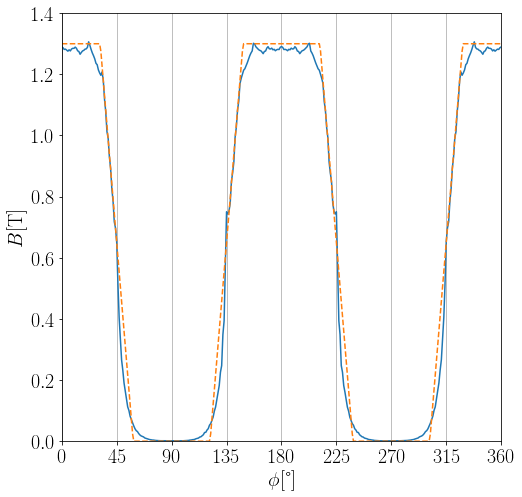

In [15]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig_g = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes_g = profile_fig_g.add_subplot(111)

teslamax_playground = str(Path.home() / "code" / "TeslaMax" / "teslamax-play" )

tmm_g = TeslaMaxModel(tmpd,
                      alpha_B_rem_g,
                      path=teslamax_playground)
tmm_g.run()
phi_vector_g, B_vector_g = tmm_g.get_profile_data().T

profile_axes_g.plot(phi_vector_g,B_vector_g)
profile_axes_g.set_xlim(0,np.max(phi_vector_g))
profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
profile_axes_g.xaxis.grid(True)
profile_axes_g.set_ylim(0,B_high+0.1)
profile_axes_g.set_yticks(np.arange(0,B_high+0.2,0.2))
profile_axes_g.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes_g.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_low,field_fraction)
profile_axes_g.plot(phi_vector_g,B_inst_vector,'--')

save_figure(profile_fig_g,"profile_optimized_B_%d_FM_%d" %(B_high*1000,field_fraction*100))

In [16]:
teslamax.calculate_average_high_field(tmm_g.get_profile_data())

1.1648571111111108

In [17]:
tmpd.calculate_functional_gradient(alpha_B_rem_g,functional_args)

array([ -4.73954209e-06,  -3.38662431e-06,   4.08285517e-03,
         5.61994895e-07,   9.48174872e-06,   3.22075699e-06,
         1.97397654e-06])

In [18]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(alpha_B_rem_g,functional_args))

array([ 0.00794521, -0.00198834,  0.00311519,  0.00017918,  0.00031675,
        0.00186631,  0.00122225])

## Optimization using evolutionary algorithms

In [ ]:
from scipy.optimize import differential_evolution, basinhopping

In [ ]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

n = len(alpha_B_rem_0)

tmpd = TeslaMaxPreDesign(params_optimization)

In [ ]:
%%time 
## all this methods from the TeslaMaxPreDesign class accept as only arguments the design vector (with remanence angles)

objective_function = tmpd.calculate_functional

bounds = [(0.0, 360.0) for i in range(0,n)]

res = differential_evolution(objective_function,bounds,disp=True)

In [ ]:
res.x

In [ ]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(tmpd,res.x,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

save_figure(profile_fig,"profile_optimized_genetic_B_13")

In [ ]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

In [ ]:
tmpd.calculate_functional_gradient(res.x)

In [ ]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(res.x))